<a href="https://colab.research.google.com/github/shreeganeshasharma/ParticleSimulations/blob/main/2DWithoutPores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D1 = 1, D2 = 10
___
https://journals.aps.org/pre/supplemental/10.1103/PhysRevE.105.014604
___

# Initialization

In [1]:
#necessary libraries
import time
import math
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

#Brownian motion parameters
#Dimensions - 1, 2 or 3
dim = 2
#Time step
dt = 0.001
#Number of steps
nums = 1000
#Number of particles
nump = 1000
#Radius of the inner ball, reflecting boundary with pores
R1 = 0.5
#Radius of the outer ball, completely reflecting boundary
R2 = 1
#Diffusivity of inner medium
D1 = 1
#Diffusivity of outer medium
D2 = 10

#Radius of the target at the center
R = R1 / 5
"""Get r0 value from paper"""
#Hitting times if the target is hit
hittingTime = np.zeros(nump)

#Parameters of the normal distribution
mean = np.zeros(dim)
covar = np.identity(dim)

#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

#Random steps
Eps = np.random.multivariate_normal(mean, covar, (nump, nums))
dX1s = np.sqrt(2*D1*dt)*Eps
dX2s = np.sqrt(2*D2*dt)*Eps

#nump particles starting at init
Init1D = np.tile(np.array([2]), nump)
Init2D = np.tile(np.array([[2], [0]]), nump)
Init3D = np.tile(np.array([[2], [0], [0]]), nump)

"""Initialize X[:, 0] here
Initialize counts for t=0"""

'Initialize X[:, 0] here\nInitialize counts for t=0'

#Simulate Ito Convention

In [ ]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      """To do - Remove the particle once it hits the target, how to do?"""
      X[:, j+1:] = np.transpose(np.tile(X[:, j - 1] + dX1, (nums-(j+1), 1)))
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

nump =  1000 nums =  1000 --- 18.48393964767456 seconds ---


In [ ]:
"""
for t in range(nums):
  print(Y[:, t, :])
  for p in range(nump):
    print(np.linalg.norm(Y[:, t, p]))
"""

'\nfor t in range(nums):\n  print(Y[:, t, :])\n  for p in range(nump):\n    print(np.linalg.norm(Y[:, t, p]))\n'

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  for p in range(nump):
    count3[t] = np.count_nonzero((0 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R))
    count1[t] = np.count_nonzero((R < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R1))
    count2[t] = np.count_nonzero((R1 < np.linalg.norm(Y[:, t, p])) & (np.linalg.norm(Y[:, t, p]) < R2))

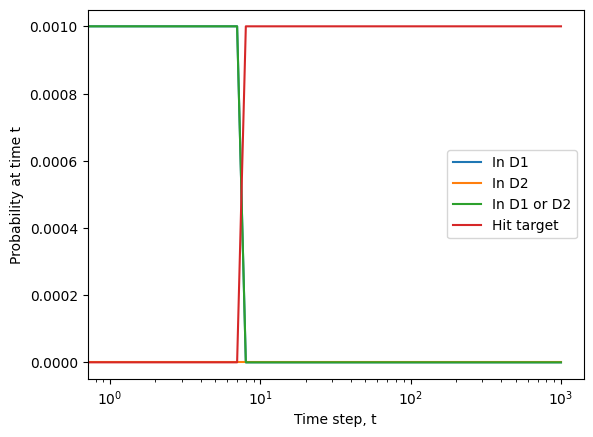

In [ ]:
plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
#plt.savefig('/content/drive/MyDrive/Images/Prob_Ito_1_10.png')

#At dt = 0.001 and nums = 1000, nump = 5000,
#Half the number of particles are still in D1 at the end of simulation.
#Increase dt to 0.01
#Gaphs look similar

Mean First Passage Time =  259.2286079182631


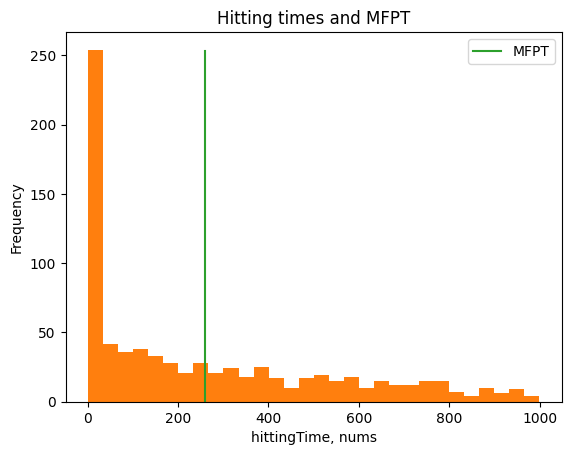

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
#plt.savefig('/content/drive/MyDrive/Images/Hit_Ito_1_10.png')

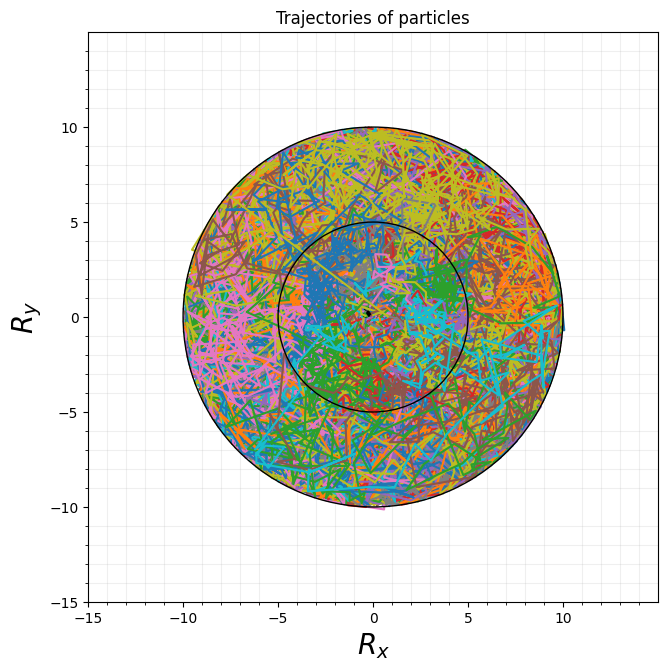

In [ ]:
#set plot params
box=3*R2
fig,ax=plt.subplots(figsize=(7.5,7.4))
ax.set_aspect(1)
ax.set_title("Trajectories of particles")
ax.set_xlabel(r"$R_x$",fontsize=20)
ax.set_ylabel(r"$R_y$",fontsize=20)
plt.xlim(-box/2,box/2)
plt.ylim(-box/2,box/2)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-box/2, box/2, box/6)
minor_ticks = np.arange(-box/2, box/2, box/30)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.grid()

for i in range(nump):
  plt.plot(Y[0, :, i], Y[1, :, i])

ax.add_artist(plt.Circle((0, 0), R1, fill = False, zorder=4))
ax.add_artist(plt.Circle((0, 0), R2, fill = False, zorder=4))
ax.add_artist(plt.Circle((0, 0), R, fill = True, color = "k"))
plt.show()

#https://www.pythonpool.com/matplotlib-circle/
#https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Ito_1_10.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw
#Which colormap facilitates distinction?

ValueError: ignored

Error in callback <function _draw_all_if_interactive at 0x7effa242e200> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 640x480 with 2 Axes>

#Simulate Stratonovich Convention

In [ ]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and 0 < np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = X[:, j - 1] + dX1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  count3[t] = np.count_nonzero((0 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R))
  count1[t] = np.count_nonzero((R < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R1))
  count2[t] = np.count_nonzero((R1 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R2))

plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Prob_Strat_1_10.png')

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Hit_Strat_1_10.png')

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Strat_1_10.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [ ]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and 0 < np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = X[:, j - 1] + dX1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  count3[t] = np.count_nonzero((0 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R))
  count1[t] = np.count_nonzero((R < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R1))
  count2[t] = np.count_nonzero((R1 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R2))

plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Prob_Iso_1_10.png')

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Hit_Iso_1_10.png')

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Iso_1_10.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# D1 = 10, D2 = 1

#Simulate Ito Convention

In [ ]:
#Diffusivity of inner medium
D1 = 10
#Diffusivity of outer medium
D2 = 1

#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])

In [ ]:
start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and 0 < np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = X[:, j - 1] + dX1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  count3[t] = np.count_nonzero((0 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R))
  count1[t] = np.count_nonzero((R < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R1))
  count2[t] = np.count_nonzero((R1 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R2))

plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Prob_Ito_10_1.png')

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Hit_Ito_10_1.png')

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Ito_10_1.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

#Simulate Stratonovich Convention

In [ ]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle travels in medium1, without hitting the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      #Diffuse to D2
      #Residence times in each medium
      dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
      dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
      #Particle diffuses, increment by motion in D2
      X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand

    #Particle diffuses from D2 to D1
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Residence times in each medium
      dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
      dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
      #Particle diffuses, increment by motion in D1
      X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand

    #Particle hits the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and 0 < np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = X[:, j - 1] + dX1
      hittingTime[i] = j
      break

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  count3[t] = np.count_nonzero((0 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R))
  count1[t] = np.count_nonzero((R < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R1))
  count2[t] = np.count_nonzero((R1 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R2))

plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Prob_Strat_10_1.png')

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Hit_Strat_10_1.png')

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Strat_10_1.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw

# Simulate Isothermal Convention

In [ ]:
#Hitting times if the target is hit
hittingTime = np.zeros(nump)
#Trajectory of a particle
X = np.zeros([dim, nums])
#Trajectories of all particles
Y = np.zeros([dim, nums, nump])


start_time = time.time()
for i in range(nump):
  #Initialize - The particle starts at a random positio outside the target
  if dim == 1:
    X[:, 0] = Init1D[i]
  elif dim == 2:
    X[:, 0] = Init2D[:, i]
  elif dim == 3:
    X[:, 0] = Init3D[:, i]

  #Find particle trajectories
  for j in range(1, nums):
    #Random increment in the position
    dRand = Eps[i, j, :]
    #Increment if particle is in medium1
    dX1 = dX1s[i, j, :]
    #Increment if particle is in medium2
    dX2 = dX2s[i, j, :]

    #Particle hits the target
    if R < np.linalg.norm(X[:, j - 1]) < R1 and 0 < np.linalg.norm(X[:, j - 1] + dX1) < R:
      X[:, j] = X[:, j - 1] + dX1
      X[:, j+1:] = X[:, j - 1] + dX1
      hittingTime[i] = j
      break

    #Particle travels in medium1, without hitting the target
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and R < np.linalg.norm(X[:, j - 1] + dX1) < R1:
      X[:, j] = X[:, j - 1] + dX1

    #Particle is traveling in medium2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and R1 < np.linalg.norm(X[:, j - 1] + dX2) < R2:
      X[:, j] = X[:, j - 1] + dX2

    #Particle is reflected by the outer ball when its next step crosses the bound R2
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) > R2:
      #Find the point of reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) + np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R2**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      #Image in D2
      X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D1 to D2 with a one sided reflection coefficient
    elif R < np.linalg.norm(X[:, j - 1]) < R1 and np.linalg.norm(X[:, j - 1] + dX1) > R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX1) + np.sqrt(np.dot(X[:, j - 1], dX1)**2 - (np.linalg.norm(dX1)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX1)**2)
      r0 = X[:, j - 1] + lamb*dX1
      if bernoulli.rvs(min(1, math.sqrt(D2/D1))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt1 = (np.linalg.norm(lamb*dX1)/(np.linalg.norm(dRand)*np.sqrt(2*D1)))**2
        dt2 = ((1 - np.sqrt(dt1/dt))**2)*dt
        #Particle diffuses, increment by motion in D2
        X[:, j] = r0 + np.sqrt(2*D2*dt2)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX2 - 2*(1 - lamb)*np.dot(dX2, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

    #Particle diffuses from D2 to D1 with a one sided reflection coefficient
    elif R1 < np.linalg.norm(X[:, j - 1]) < R2 and np.linalg.norm(X[:, j - 1] + dX2) < R1:
      #Find the point of diffusion/reflection
      lamb = ( -np.dot(X[:, j - 1], dX2) - np.sqrt(np.dot(X[:, j - 1], dX2)**2 - (np.linalg.norm(dX2)**2)*(np.linalg.norm(X[:, j - 1])**2 - R1**2)) )/(np.linalg.norm(dX2)**2)
      r0 = X[:, j - 1] + lamb*dX2
      if bernoulli.rvs(min(1, math.sqrt(D1/D2))):
        #Diffuse with time-splitting, if the random variable generated is 1
        #Residence times in each medium
        dt2 = (np.linalg.norm(lamb*dX2)/(np.linalg.norm(dRand)*np.sqrt(2*D2)))**2
        dt1 = ((1 - np.sqrt(dt2/dt))**2)*dt
        #Particle diffuses, increment by motion in D1
        X[:, j] = r0 + np.sqrt(2*D1*dt1)*dRand
      else:
        #Reflect, if the random variable generated is 0
        X[:, j] = X[:, j - 1] + dX1 - 2*(1 - lamb)*np.dot(dX1, r0/np.linalg.norm(r0)) * r0/np.linalg.norm(r0)

  #Save the particle's trajectory
  Y[:, :, i] = X
  #print(i)

#Time taken to simulate motion of nump particles each taking nums steps
print("nump = ", nump, "nums = ", nums, "--- %s seconds ---" % (time.time() - start_time))

# Plots

In [ ]:
#Probability of finding a particle in medium1 or medium2 or hiting the target
count1 = np.zeros(nums)
count2 = np.zeros(nums)
count3 = np.zeros(nums)
for t in range(nums):
  count3[t] = np.count_nonzero((0 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R))
  count1[t] = np.count_nonzero((R < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R1))
  count2[t] = np.count_nonzero((R1 < Y[:, t, :].flatten()) & (Y[:, t, :].flatten() < R2))

plt.xscale("log")
plt.plot(count1/nump)
plt.plot(count2/nump)
plt.plot((count1 + count2)/nump)
plt.plot(count3/nump)
#plt.plot(np.tile(MFPT/nums, nums))
plt.legend(["In D1", "In D2", "In D1 or D2", "Hit target","MFPT"])
plt.xlabel("Time step, t")
plt.ylabel("Probability at time t")
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Prob_Iso_10_1.png')

In [ ]:
#Histogram hitting times and plot MFPT
hit = hittingTime[hittingTime != 0]
#Should zero be removed for MFPT calculation?
MFPT = np.average(hit)
print("Mean First Passage Time = ", MFPT)
plt.plot(np.tile(MFPT, int(max(plt.hist(hit, 30)[0]))), range(int(max(plt.hist(hit, 30)[0]))), label="MFPT")
#plt.hist(hit, 30, label="Zero removed")
#plt.hist(hittingTime, 30, label="Zero inflated")
plt.ylabel("Frequency")
plt.xlabel("hittingTime, nums")
plt.title("Hitting times and MFPT")
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Images/Hit_Iso_10_1.png')

In [ ]:
#https://note.nkmk.me/en/python-numpy-count/

gridX = 100
pos = np.round(np.linspace(0, 1, gridX + 1), 2)
gridT = nums
tim = np.linspace(0, gridT, gridT+1)
#Heatmap matrix for 1d
PDF1D = np.zeros((gridT, gridX+1))

#Quantize norm matrix Y for heatmap upto 2 decimal places
Z = np.round(Y/R2, 2)

if dim == 1:
  for t in range(nums):
    #position of all particles at time t
    for p in range(len(pos)):
      PDF1D[t][p] = len(np.where(Z[0, t, :] == pos[p])[0])
"""How to normalize the matrix PDF1D?
Divide by maximum or row sum or col sum"""


#Plot the heatmap of pdf
plt.title("PDF of particles")
#PDF1D is a 2D matrix with (0,0)th element on top left. Fip vertically
plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log")
#plt.imshow(np.flipud(PDF1D), extent = [0, 1, 0, 1], cmap= "gnuplot", aspect = "auto", norm="log", vmin=0.001, vmax=1000)
plt.xlabel("Distance, x")
plt.ylabel("Time, t")
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Images/Heat_Ito_10_1.png')
#https://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw